In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pprint as pp
import imp
import matplotlib.pyplot as plt
import networkx as nx
from nxpd import draw
import seaborn as sn

sn.set_context('notebook')

# Norway Pollutant Export model

This notebook illustrates the basic usage of a simple export coefficient model based loosely on [TEOTIL](https://brage.bibsys.no/xmlui/bitstream/handle/11250/214825/5914-2010_72dpi.pdf?sequence=1&isAllowed=y). The [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model_inputs.ipynb) described preparation of the input file for the new model, and the model code itself can be found [here](https://github.com/JamesSample/rid/blob/master/notebooks/nope.py). In addition, [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/simple_network_model.ipynb) provides a brief introduction to network graphs in Python.

Note that the model here is still pretty rough and will require further development and debugging before being applied in practice. The aim here is simply to investigate whether a TEOTIL-like model can be implemented easily in Python.

In [2]:
# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')

nope = imp.load_source('nope', nope_path)

## 1. Run model

The new model is very easy to run - simply point it to the input file (created [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model_inputs.ipynb)) and call `nope.run_model()`. In the code below, we use `%%time` to measure the total runtime (reading the inputs and performing the network accumulation).

In [3]:
%%time
# Input file (see previous notebook)
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\nope_input_data.csv')

# Run model
g = nope.run_nope(in_csv)

Wall time: 5.49 s


On my laptop, the new model takes around 5 seconds to process the data for N and P. Running TEOTIL for the same two parameters on the same machine takes approximately 8 hours, so the new model, without any optimisation, is more than 5000 times faster. This difference in performance opens up opportunities for improved testing and calibration, as well as making it much easier to use.

## 2. Explore output

### 2.1. Basic data access

The model returns a "network object", where each node in the network corresponds to a catchment. Each node has two data stores associated with it: one containing the `local` inputs from each specific regine catchment, and a second called `accum` which stores accumulated results (i.e. including upstream inputs and allowing for retention). These properties can be queried as follows:

In [4]:
# Get local data for catchment '001.1A40'
print 'Local data for "001.1A40":'
pp.pprint(g.node['001.1A40']['local'])
print ''

# Get accum data for catchment '001.1A40'
print 'Accumulated data for "001.1A40":'
pp.pprint(g.node['001.1A40']['accum'])

Local data for "001.1A40":
{'a_reg_km2': 12.37,
 'all_point_n_tonnes': 0.7146448805069999,
 'all_point_p_tonnes': 0.0553334108425,
 'all_sources_n_tonnes': 7.4610984019,
 'all_sources_p_tonnes': 0.327036204762,
 'anth_diff_n_tonnes': 3.57053592494,
 'anth_diff_p_tonnes': 0.223507766884,
 'aqu_n_tonnes': 0.0,
 'aqu_p_tonnes': 0.0,
 'ind_n_tonnes': 0.0,
 'ind_p_tonnes': 0.0,
 'nat_diff_n_tonnes': 3.1759175964499997,
 'nat_diff_p_tonnes': 0.048195027035400004,
 'q_reg_m3/s': 0.170257993391,
 'regine': '001.1A40',
 'regine_ned': '001.1A3',
 'ren_n_tonnes': 0.0,
 'ren_p_tonnes': 0.0,
 'runoff_mm/yr': 434.054654777,
 'spr_n_tonnes': 0.425141672161,
 'spr_p_tonnes': 0.0319314964234,
 'trans_n': 1.0,
 'trans_p': 1.0}

Accumulated data for "001.1A40":
{'all_point_n_tonnes': 1.6177791441419354,
 'all_point_p_tonnes': 0.08619126745694974,
 'all_sources_n_tonnes': 45.68624566524923,
 'all_sources_p_tonnes': 0.7575869176492867,
 'anth_diff_n_tonnes': 6.8975003744165395,
 'anth_diff_p_tonnes': 0.345

### 2.2. Network diagrams

The model can create schematic diagrams upstream and downstream from any node. These can be annotated with any output value the user chooses. Note that if the user specifies "direct='up'", *the arrows on the schematic will point upstream*.

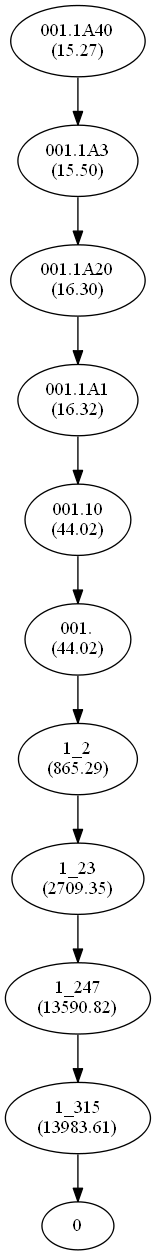

In [5]:
# Plot network labelled with accumulated flow
g2 = nope.plot_network(g, '001.1A40', direct='down', stat='accum', quant='q_m3/s')
draw(g2, show='ipynb')

### 2.3. Summary maps

The user can also choose `local` or `accum` and specify a parameter of interest to generate a simple map. Note that this can take a minute or so, as rendering the regine polygons is computationally intensive. Optionally, the data can be square-root transformed before plotting, and different colour schemes can be applied. The plot can also be saved as an image file by specifying the `plot_path`.

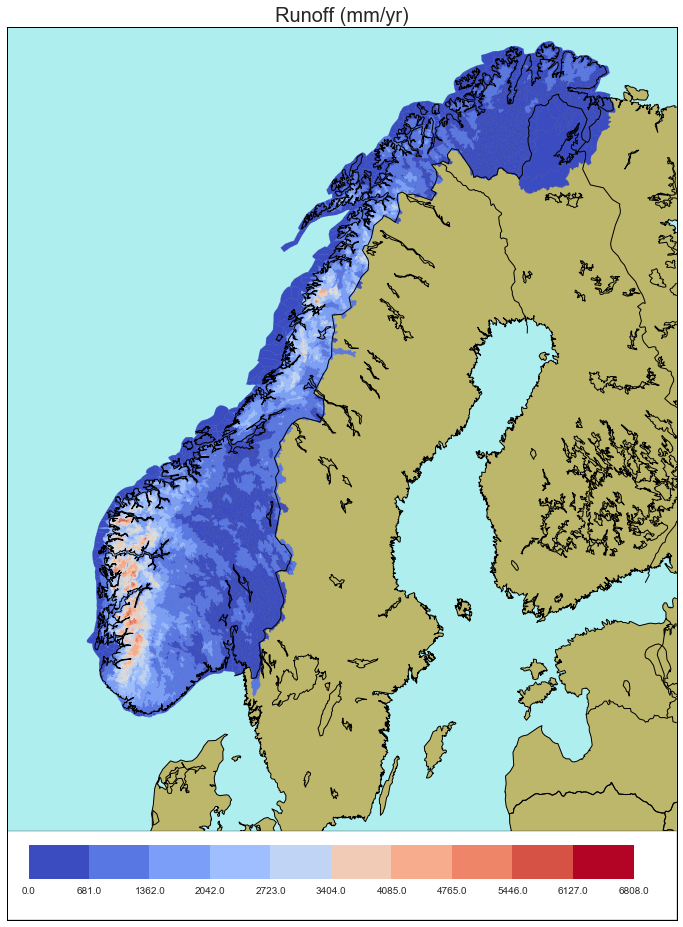

In [6]:
# Summary map of local runoff
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\PNG_Maps\runoff.png')

fig = nope.make_map(g, stat='local', quant='runoff_mm/yr', sqrt=False,
                    cmap='coolwarm', n_cats=10, plot_path=out_png)

### 2.4. Write results to CSV

The graph can be easily converted to CSV format for further analysis.

In [7]:
# Save results as csv
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\nope_results_2015.csv')
df = nope.model_to_dataframe(g, out_path=out_csv)

df.head()

,regine,regine_ned,accum_all_point_n_tonnes,accum_all_point_p_tonnes,accum_all_sources_n_tonnes,accum_all_sources_p_tonnes,accum_anth_diff_n_tonnes,accum_anth_diff_p_tonnes,accum_aqu_n_tonnes,accum_aqu_p_tonnes,...,local_nat_diff_n_tonnes,local_nat_diff_p_tonnes,local_q_reg_m3/s,local_ren_n_tonnes,local_ren_p_tonnes,local_runoff_mm/yr,local_spr_n_tonnes,local_spr_p_tonnes,local_trans_n,local_trans_p
0,001.222Z,001.2220,0.182143,0.014103,2.537672,0.088162,0.910032,0.056966,0.0,0.0,...,1.445496,0.017093,0.085473,0.0,0.0,434.054655,0.108357,0.008138,1.00,1.00
1,002.DGBZ,002.DGB0,0.000000,0.000000,6.429953,0.137348,0.000000,0.000000,0.0,0.0,...,6.628818,0.165480,0.989583,0.0,0.0,362.624731,0.000000,0.000000,0.97,0.83
2,123.A1Z,123.A12,0.556533,0.025826,16.243852,0.310777,11.190607,0.246177,0.0,0.0,...,5.551497,0.129247,0.636149,0.0,0.0,503.427805,0.450727,0.065091,0.81,0.30
3,212.FAC,212.FAB0,0.021639,0.000779,6.659931,0.068712,0.000000,0.000000,0.0,0.0,...,6.987676,0.089385,0.495119,0.0,0.0,287.234419,0.022777,0.001025,0.95,0.76
4,135.1AC,135.1AB,0.000000,0.000000,5.817807,0.060086,0.000000,0.000000,0.0,0.0,...,6.844479,0.143063,1.092563,0.0,0.0,2452.318450,0.000000,0.000000,0.85,0.42


## 3. Compare results to observed data

The new model is uncalibrated, so I don't expect it to be particularly accurate yet. However, because it is similar in design to TEOTIL and because TEOTIL *has* been previously calibrated, the output might not be too bad. Overall, I would expect the results to be similar to those produced by TEOTIL, but not necessarily the same as the observed values.

The easiest way to evaluate the output is therefore to link the new model results to those from TEOTIL for 2015. However, restructuring the TEOTIL output seems messy: most of the work is done in this Access database

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Rekonstruksjon\db1.mdb

and, even after looking at it for a while, I have absolutely no idea what's going on here!

A more rigourous test is to compare the model results to observed values. The code below reads the load estimates for 2015 for the sites where water chemistry is measured (i.e. the `RID_11` and `RID_36` stations). These observed loads are then compared to predictions from my new - but uncalibrated - model. 

**Note the log-log scale on the plots below due to large data ranges**

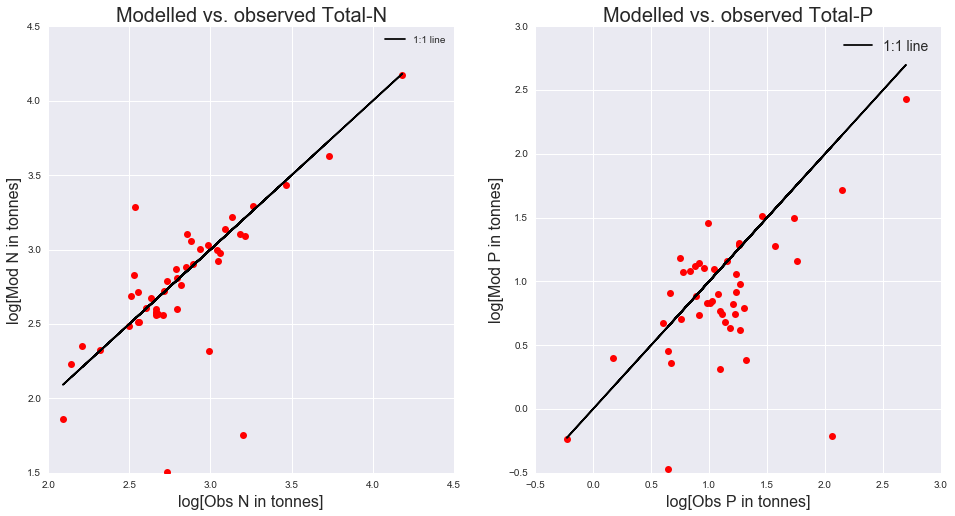

In [8]:
# Read station data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\rid_loads_summaries_2016.xlsx')
stn_df = pd.read_excel(in_xlsx, sheetname='station_data')

# Consider just the RID_11 and RID_36 stations
stn_df = stn_df.query('rid_group != "rid_108"')

# Get just cols of interest
stn_df = stn_df[['station_id', 'station_code', 'station_name', 'nve_vassdrag_nr']]

# Read 2015 observed loads for N and P
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Results\Loads_CSVs\loads_all_sites_2015.csv')
lds_df = pd.read_csv(in_csv, encoding='utf-8')
lds_df = lds_df[['station_id', 'TOTN_tonnes', 'TOTP_tonnes']]

# Join
df = pd.merge(stn_df, lds_df, how='left', on='station_id')

# Container for output
n_list = []
p_list = []

# Loop over model data
for idx, row in df.iterrows():
    stn_id = row['station_id']
    vnr = row['nve_vassdrag_nr']
    
    # Get data from graph
    try :
        mod_n = g.node[vnr]['accum']['all_sources_n_tonnes']
        mod_p = g.node[vnr]['accum']['all_sources_p_tonnes'] 

        n_list.append(mod_n)
        p_list.append(mod_p)
    
    except KeyError:
        n_list.append(np.nan)
        p_list.append(np.nan)         

# Add to df
df['Mod_TOTN_tonnes'] = n_list
df['Mod_TOTP_tonnes'] = p_list

# Get cols of interest and drop NaN
df = df[['TOTN_tonnes', 'TOTP_tonnes', 'Mod_TOTN_tonnes', 'Mod_TOTP_tonnes']]
df.dropna(inplace=True)

# Log transform
df = np.log10(df)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# N
axes[0].plot(df['TOTN_tonnes'], df['Mod_TOTN_tonnes'], 'ro', label='')
axes[0].plot(df['TOTN_tonnes'], df['TOTN_tonnes'], 'k-', label='1:1 line')
axes[0].set_title('Modelled vs. observed Total-N', fontsize=20)
axes[0].set_xlabel('log[Obs N in tonnes]', fontsize=16)
axes[0].set_ylabel('log[Mod N in tonnes]', fontsize=16)
axes[0].legend(loc='best')

axes[1].plot(df['TOTP_tonnes'], df['Mod_TOTP_tonnes'], 'ro', label='')
axes[1].plot(df['TOTP_tonnes'], df['TOTP_tonnes'], 'k-', label='1:1 line')
axes[1].set_title('Modelled vs. observed Total-P', fontsize=20)
axes[1].set_xlabel('log[Obs P in tonnes]', fontsize=16)
axes[1].set_ylabel('log[Mod P in tonnes]', fontsize=16)
axes[1].legend(loc='best', fontsize=14)

plt.show()

Overall, I'd say this is a pretty good initial result: the model does fairly well at simulating N, and it's not terrible for P either. In general, the model underestimates P loads - something that has previously been noted when using TEOTIL (see e.g. section 3.1, page 21 of the [TEOTIL report](https://brage.bibsys.no/xmlui/bitstream/handle/11250/214825/5914-2010_72dpi.pdf?sequence=1&isAllowed=y)). There are many ways in which this model could be further improved, but at first glance it looks as though it's at least simulating the correct quantities and producing results that are comparable to those observed in major Norwegian catchments.

## Summary

This notebook presents a very simple export-coefficient-based model underpinned by Python and NetworkX. The actual model consists of just 100 lines of code (excluding the plotting functions) and, in the context of the RID project, the output seems very comparable to that produced by TEOTIL. It also runs approximately 5000 times faster.

Note that TEOTIL offers a number of features not yet implemented here, but if we just need a simple way of estimating annual loads in unmonitored areas for the RID project, this new model should be easier to use and quicker to develop than the old one.